# II Features of genes linked to 2+ monogenic disorders

##### - Number of asscoiated monogenic disorders with each gene
##### - Constraint metrics (pLI, LOEUF)
##### - HPO terms per gene
##### - Enrichment Analysis

# Library

## Python libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import rpy2

## R and R packages 

In [2]:
%load_ext rpy2.ipython
#%reload_ext rpy2.ipython

In [3]:
%%R
library(dplyr)
library(tidyr)
library(ggplot2)
library(scales)
library(qqman)
library(hexbin)
library(RColorBrewer)
library(enrichplot)
library(clusterProfiler)
library(msigdbr)
library(gridExtra)

R[write to console]: 
Присоединяю пакет: ‘dplyr’


R[write to console]: Следующие объекты скрыты от ‘package:stats’:

    filter, lag


R[write to console]: Следующие объекты скрыты от ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: 

R[write to console]: For example usage please run: vignette('qqman')

R[write to console]: 

R[write to console]: Citation appreciated but not required:

R[write to console]: Turner, (2018). qqman: an R package for visualizing GWAS results using Q-Q and manhattan plots. Journal of Open Source Software, 3(25), 731, https://doi.org/10.21105/joss.00731.

R[write to console]: 

R[write to console]: Registered S3 method overwritten by 'enrichplot':
  method               from
  fortify.enrichResult DOSE

R[write to console]: clusterProfiler v3.14.3  For help: https://guangchuangyu.github.io/software/clusterProfiler

If you use clusterProfiler in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Yanyan Han, Qing-Yu He

# Load data

In [4]:
! mkdir interm

In [19]:
# HPOdata
hpo = pd.read_csv('hpo_table.csv', sep='\t')   # gene-diseases associations + inheritance paatern

print(hpo.head(2))
print(hpo.shape)

     GENE         OMIM Inheritance          Ensembl
0  A4GALT  OMIM:111400          AD  ENSG00000128274
1    AAAS  OMIM:231550          AR  ENSG00000094914
(5358, 4)


In [ ]:
# ClinVar data
cv = pd.read_csv('ClinVarTable_grch38_20230326_PLP_OMIM.txt', sep='\t')   # filtered .vcf: P/LP variants annotated to diseases

print(cv.head(2))
print(cv.shape)

In [73]:
# merge Clinvar and HPO dataframe
df = pd.merge(cv, hpo, on=['GENE', 'OMIM'], how='inner')

# statistics
print(df.shape)
print('N of variants:', df['ID'].drop_duplicates().shape[0])
print('N of genes:', df['GENE'].drop_duplicates().shape[0])
print('N of gene-MIM associations:', df[['GENE', 'OMIM']].drop_duplicates(keep='first').shape[0])

In [7]:
# save merged dataframe
df.to_csv('Clinvar_grch38_20230326_PLP_HPO.csv', sep='\t', index=False)

# Count number of associated diseases per gene

In [21]:
#in hpo data only

print(hpo.shape)
print('N of genes:', hpo['GENE'].drop_duplicates().shape[0])
print('N of gene-MIM associations:', hpo[['GENE', 'OMIM']].drop_duplicates(keep='first').shape[0])
print('N of MIMs:', hpo[['OMIM']].drop_duplicates(keep='first').shape[0])

(5358, 4)
N of genes: 3904
N of gene-MIM associations: 5352
N of MIMs: 5041


In [22]:
# count MIMs associated with each gene

gene_mim = hpo[['GENE', 'OMIM']].drop_duplicates()
gene_mim = gene_mim.groupby(['GENE']).size().reset_index(name='MIMs_per_Gene')
gene_mim.head(2)

,GENE,MIMs_per_Gene
0,A4GALT,1
1,AAAS,1


In [10]:
%%R -i gene_mim

mim_per_gene <- gene_mim
head(mim_per_gene)

    GENE MIMs_per_Gene
0 A4GALT             1
1   AAAS             1
2  AAGAB             1
3  AARS1             3
4  AARS2             2
5   AASS             1


In [11]:
%%R

mim_per_gene_c <- as.data.frame(table(mim_per_gene$MIMs_per_Gene))
head(mim_per_gene_c)

  Var1 Freq
1    1 2972
2    2  625
3    3  195
4    4   63
5    5   25
6    6   10


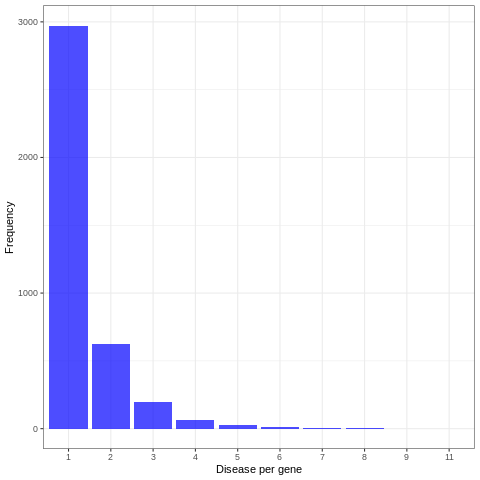

In [12]:
%%R

ggplot(mim_per_gene_c, aes(x=Var1, y=Freq)) + geom_bar(stat='identity', fill='blue', alpha=0.7) + 
xlab('Disease per gene') + ylab('Frequency') + theme_set(theme_gray(base_family = "DejaVu")) + theme_bw()

In [14]:
%%R

write.csv(mim_per_gene_c, 'GeneMulPheno_hpo_data.csv', quote=FALSE, row.names=FALSE)

#####  save N of diseases per gene to merged ClinVar-HPO dataframe

In [4]:
df = pd.read_csv('Clinvar_grch38_20230326_PLP_HPO.csv', sep='\t')
df.head(2)

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,GENE,CLNSIG,MC,OMIM,Inheritance,Ensembl
0,chr1,1013983,1028857,G,A,-10.0,PASS,ISG15,Pathogenic,splice_acceptor_variant,OMIM:616126,AR,ENSG00000187608
1,chr1,1014143,183381,C,T,-10.0,PASS,ISG15,Pathogenic,nonsense,OMIM:616126,AR,ENSG00000187608


In [5]:
print(df.shape)
print('N of variants:', df['ID'].drop_duplicates().shape[0])
print('N of genes:', df['GENE'].drop_duplicates().shape[0])
print('N of gene-MIM associations:', df[['GENE', 'OMIM']].drop_duplicates(keep='first').shape[0])

(87985, 13)
N of variants: 74365
N of genes: 3578
N of gene-MIM associations: 4850


In [6]:
# count MIMs associated with each gene

gene_mim = df[['GENE', 'OMIM']].drop_duplicates()
gene_mim = gene_mim.groupby(['GENE']).size().reset_index(name='MIMs_per_Gene')
gene_mim.head(2)

,GENE,MIMs_per_Gene
0,AAAS,1
1,AAGAB,1


In [23]:
print('N of genes:', gene_mim.drop_duplicates().shape[0])
print('N of genes with 2+ associated diseases:', gene_mim[gene_mim['MIMs_per_Gene'] > 1].drop_duplicates().shape[0])
print('N of genes with 2 associated diseases:', gene_mim[gene_mim['MIMs_per_Gene'] == 2].drop_duplicates().shape[0])

N of genes: 3904
N of genes with 2+ associated diseases: 932
N of genes with 2 associated diseases: 625


In [12]:
# add number of associated diseases to initial df

df_m = df.merge(gene_mim, how='inner')
df_m.head(3)

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,GENE,CLNSIG,MC,OMIM,Inheritance,Ensembl,MIMs_per_Gene
0,chr1,1013983,1028857,G,A,-10.0,PASS,ISG15,Pathogenic,splice_acceptor_variant,OMIM:616126,AR,ENSG00000187608,1
1,chr1,1014143,183381,C,T,-10.0,PASS,ISG15,Pathogenic,nonsense,OMIM:616126,AR,ENSG00000187608,1
2,chr1,1014316,161455,C,CG,-10.0,PASS,ISG15,Pathogenic,frameshift_variant,OMIM:616126,AR,ENSG00000187608,1


In [13]:
df_m.to_csv('./Clinvar_grch38_20230326_PLP_HPO_MIMcount.csv', sep='\t', index=False)

## Constraint metrics

source: https://gnomad.broadinstitute.org/

In [44]:
! wget https://storage.googleapis.com/gcp-public-data--gnomad/release/2.1.1/constraint/gnomad.v2.1.1.lof_metrics.by_gene.txt.bgz
    
! gunzip -c  gnomad.v2.1.1.lof_metrics.by_gene.txt.bgz  | cut -f1,21,30,36 > ./data/gnomad.v2.1.1.pli_loeuf.txt

--2023-04-05 10:04:23--  https://storage.googleapis.com/gcp-public-data--gnomad/release/2.1.1/constraint/gnomad.v2.1.1.lof_metrics.by_gene.txt.bgz
Распознаётся storage.googleapis.com (storage.googleapis.com)… 142.250.74.144, 142.250.74.176, 216.58.207.240, ...
Подключение к storage.googleapis.com (storage.googleapis.com)|142.250.74.144|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 4609488 (4,4M) [application/octet-stream]
Сохранение в: «gnomad.v2.1.1.lof_metrics.by_gene.txt.bgz.1»

gnomad.v2.1.1.lof_m 100%[===================>]   4,40M  5,12MB/s    за 0,9s    

2023-04-05 10:04:25 (5,12 MB/s) - «gnomad.v2.1.1.lof_metrics.by_gene.txt.bgz.1» сохранён [4609488/4609488]



In [24]:
# pLI & loeuf data from gnomAD

gnomad = pd.read_csv('./data/gnomad.v2.1.1.pli_loeuf.txt', sep='\t')
gnomad.head(2)

,gene,pLI,oe_lof_upper,oe_lof_upper_bin
0,MED13,1.0,0.030,0.0
1,NIPBL,1.0,0.032,0.0


In [25]:
# select genes that are in hpo df
genes = hpo[['GENE']].drop_duplicates()
genes.shape

(3904, 1)

In [26]:
gnomad_flt = pd.merge(gnomad, genes, left_on=['gene'], right_on=['GENE'], how='inner')
gnomad_flt.shape

(3684, 5)

In [27]:
# select genes with 2+ pheno

genesMulPh = gene_mim[gene_mim['MIMs_per_Gene'] > 1]
genesMulPh = genesMulPh[['GENE']].drop_duplicates()
genesMulPh.shape

(932, 1)

### pLI 

In [28]:
# select pLI

gn_pLI = gnomad_flt[['GENE', 'pLI']]

In [29]:
# mark genes with 1 and 2+ associated diseases

pLI = pd.merge(gn_pLI, genesMulPh, on=['GENE'], how='left', indicator='Multiple_phenotypes')
pLI['Multiple_phenotypes'] = np.where(pLI.Multiple_phenotypes == 'both', True, False)
pLI.shape

(3684, 3)

In [22]:
pLI.to_csv('pLI_dfgenes.csv', sep='\t', index=False)

In [54]:
pLI = pd.read_csv('pLI_dfgenes.csv', sep='\t')

In [30]:
%%R -i pLI

pLI$pLI <- as.character(pLI$pLI)
pLI$pLI <- as.numeric(pLI$pLI)

print(nrow(pLI[pLI$Multiple_phenotypes == 'TRUE', ]))
print(nrow(pLI[pLI$Multiple_phenotypes == 'FALSE', ]))

[1] 898
[1] 2786


In [46]:
%%R

# classify pLI value 

pLI <- pLI %>% 
  mutate(class = case_when(
    pLI <= 0.1 ~ 'pLOF tolerant (pLI <=0.1)',
    pLI >= 0.9 ~ 'pLOF intolerant (pLI >=0.9)',
    pLI > 0.1 & pLI < 0.9 ~ 'intermediate tolerance'))

# count
stat_pli <- na.omit(pLI)%>%
  group_by(Multiple_phenotypes, class) %>%
  summarize(count = n()) %>%
  mutate(prop = (count/sum(count)))


stat_pli
write.csv(stat_pli, './interm/pli_hpo.csv', sep='\t', quote=FALSE)

`summarise()` has grouped output by 'Multiple_phenotypes'. You can override
using the `.groups` argument.


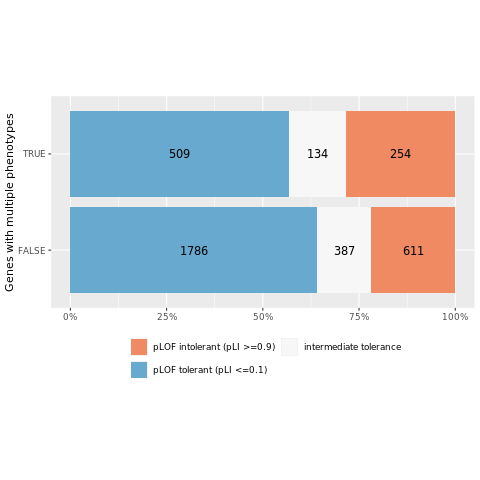

In [26]:
%%R

pli_bar <- ggplot(na.omit(stat_pli), aes(y=prop, x=Multiple_phenotypes, label=count,
                               fill=factor(class, levels=c("pLOF intolerant (pLI >=0.9)",
                                                           "intermediate tolerance",
                                                           "pLOF tolerant (pLI <=0.1)", 'NA')))) +
    geom_bar(position="stack", stat="identity")+
    theme_bw() + 
    theme(axis.text = element_text(size = 12), axis.title =  element_text(size=14), 
    legend.text=element_text(size=14)) + 
    xlab('Genes with multiple phenotypes') +  
    ylab(NULL) + 
    scale_y_continuous(labels = percent_format()) + theme_set(theme_gray(base_family = "DejaVu")) + geom_text(size = 4, position = position_stack(vjust = 0.5), family='DejaVu')

pli_bar <- pli_bar + guides(fill=guide_legend(title=NULL, nrow=2, byrow=TRUE)) + theme(legend.position="bottom") + scale_fill_brewer(palette = "RdBu")
pli_bar <- pli_bar + theme(aspect.ratio = 1/2)  + coord_flip() 
pli_bar


### LOEUF 

In [28]:
# select loeuf

gn_loeuf = gnomad_flt[['GENE', 'oe_lof_upper', 'oe_lof_upper_bin']]

In [29]:
loeuf = pd.merge(gn_loeuf, genesMulPh, on=['GENE'], how='left', indicator='Multiple_phenotypes')
loeuf['Multiple_phenotypes'] = np.where(loeuf.Multiple_phenotypes == 'both', True, False)
loeuf.shape

(3684, 4)

In [30]:
loeuf.to_csv('LOEUF_dfgenes_hpo.csv', sep='\t', index=False)

In [61]:
loeuf = pd.read_csv('LOEUF_dfgenes.csv', sep='\t')

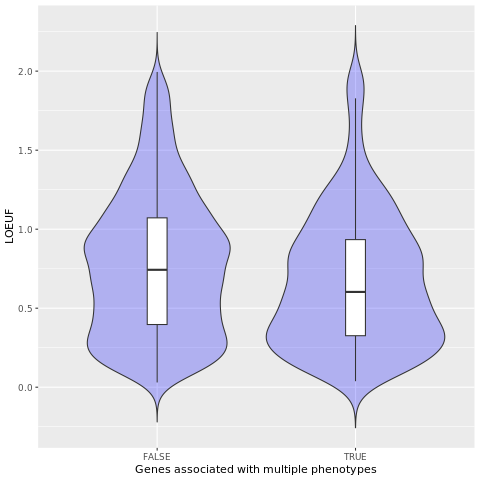

In [31]:
%%R -i loeuf

loeuf_violin <- ggplot(na.omit(loeuf), aes(x=Multiple_phenotypes, y=oe_lof_upper)) + 
                geom_violin(fill='blue', alpha=0.25, trim=FALSE) + theme_bw() + 
                theme(axis.text = element_text(size = 10), axis.title =  element_text(size=14, face="bold")) + 
                xlab('Genes associated with multiple phenotypes') + ylab('LOEUF') + theme_set(theme_gray(base_family = "DejaVu"))

loeuf_violin <- loeuf_violin + geom_boxplot(width=0.1, outlier.shape = NA)

loeuf_violin

In [34]:
%%R

# count
loeuf_dec <- na.omit(loeuf)%>%
  group_by(Multiple_phenotypes, oe_lof_upper_bin) %>%
  summarize(count = n()) %>%
  mutate(prop = (count/sum(count)))

head(loeuf_dec)
#write.csv(loeuf_dec, './loeuf_dec_hpo.csv', sep='\t', quote=FALSE)

`summarise()` has grouped output by 'Multiple_phenotypes'. You can override
using the `.groups` argument.


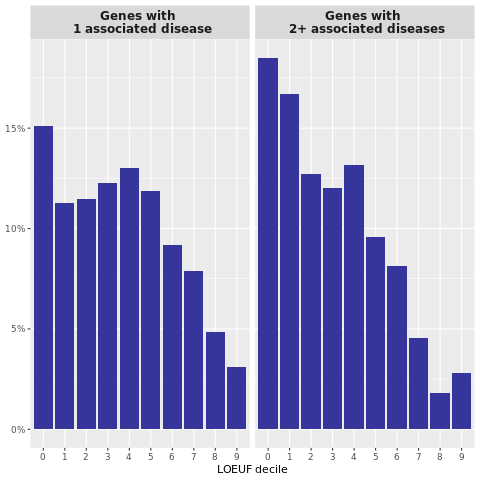

In [35]:
%%R

loeuf_dec_pl <- ggplot(na.omit(loeuf_dec), aes(x=as.factor(oe_lof_upper_bin), y=prop)) + geom_bar(stat='identity')+
 geom_bar(position="stack", stat="identity", fill='blue', alpha=0.4)+
    theme_bw() + 
    theme(axis.text = element_text(size = 12), axis.title =  element_text(size=14), 
    legend.text=element_text(size=10)) + 
    xlab('LOEUF decile') +  
    ylab(NULL) + 
    scale_y_continuous(labels = percent_format()) + theme_set(theme_gray(base_family = "DejaVu"))

genes.labs <- c("Genes with \n 1 associated disease", "Genes with \n 2+ associated diseases")
names(genes.labs) <- c("FALSE", "TRUE")
                      
loeuf_dec_pl <- loeuf_dec_pl + facet_grid(. ~ Multiple_phenotypes, labeller = labeller(Multiple_phenotypes = genes.labs)) + 
                theme(strip.text.x = element_text(size = 12, face = "bold")) 

loeuf_dec_pl

## Count number of HPO terms  per gene

In [37]:
ph_gene = pd.read_csv('./data/phenotype_to_genes_mod.txt', sep='\t')

print(ph_gene.head(3))
print(ph_gene.shape)

       HPO-id                   HPO label  entrez-gene-id    GENE  \
0  HP:0000002  Abnormality of body height            1280  COL2A1   
1  HP:0000002  Abnormality of body height          155382  VPS37D   
2  HP:0000002  Abnormality of body height            8200    GDF5   

  Additional Info from G-D source G-D source disease-ID for link  
0                             NaN  orphadata        ORPHA:166011  
1                             NaN  orphadata           ORPHA:904  
2                        question   mim2gene         OMIM:201250  
(1117566, 7)


In [38]:
list(ph_gene)

['HPO-id',
 'HPO label',
 'entrez-gene-id',
 'GENE',
 'Additional Info from G-D source',
 'G-D source',
 'disease-ID for link']

In [39]:
# select genes that are in df (hpo data)
genes = gene_mim[['GENE']].drop_duplicates()
genes.shape

(3904, 1)

In [40]:
ph_gene_flt = pd.merge(ph_gene, genes, on=['GENE'], how='inner')
ph_gene_flt.shape

(924384, 7)

In [41]:
# exclude HPO terms related to inheritance

rm = ph_gene_flt['HPO-id'].isin(['HP:0000006', 'HP:0000007', 'HP:0001419', 'HP:0001423', 'HP:0001427', 'HP:0010984', 'HP:0010982','HP:0001426', 'HP:0001428', 'HP:0001442', 'HP:0034345'])
ph_gene_flt = ph_gene_flt[~rm]
ph_gene_flt.shape

(913156, 7)

In [42]:
count_terms = ph_gene_flt[['GENE', 'HPO-id']]
count_terms = count_terms.groupby(['GENE']).size().reset_index(name='Sum_HPO')
count_terms.head()

,GENE,Sum_HPO
0,A4GALT,3
1,AAAS,241
2,AAGAB,134
3,AARS1,474
4,AARS2,137


In [43]:
# hpo data
genesMulPh = gene_mim[gene_mim['MIMs_per_Gene'] > 1]
genesMulPh = genesMulPh[['GENE']].drop_duplicates()
genesMulPh.shape

(932, 1)

In [44]:
count_terms = pd.merge(count_terms, genesMulPh, on=['GENE'], how='left', indicator='MultiplePheno')
count_terms['MultiplePheno'] = np.where(count_terms.MultiplePheno == 'both', True, False)
count_terms.shape

(3903, 3)

In [45]:
count_terms.tail()

,GENE,Sum_HPO,MultiplePheno
3898,ZP1,11,False
3899,ZP2,12,False
3900,ZP3,11,False
3901,ZSWIM6,450,True
3902,ZSWIM7,176,False


In [50]:
count_terms.to_csv('./interm/count_hpo_terms_hpo_data.csv', sep='\t', index=False)

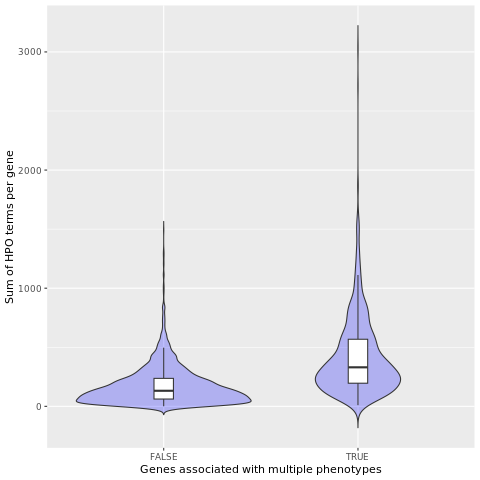

In [46]:
%%R -i count_terms


terms_v <- ggplot(count_terms, aes(x=MultiplePheno, y=Sum_HPO)) + geom_violin(fill='blue', alpha=0.25, trim=FALSE) + theme_bw() + theme(axis.text = element_text(size = 10), axis.title =  element_text(size=14, face="bold")) + xlab('Genes associated with multiple phenotypes') + ylab('Sum of HPO terms per gene')
terms_v <- terms_v + geom_boxplot(width=0.1, outlier.shape = NA) + theme_set(theme_gray(base_family = "DejaVu"))
terms_v

In [47]:
%%R -i count_terms

wilcox.test(count_terms$Sum_HPO[count_terms$MultiplePheno == 'FALSE'], count_terms$Sum_HPO[count_terms$MultiplePheno == 'TRUE'])


	Wilcoxon rank sum test with continuity correction

data:  count_terms$Sum_HPO[count_terms$MultiplePheno == "FALSE"] and count_terms$Sum_HPO[count_terms$MultiplePheno == "TRUE"]
W = 599704, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


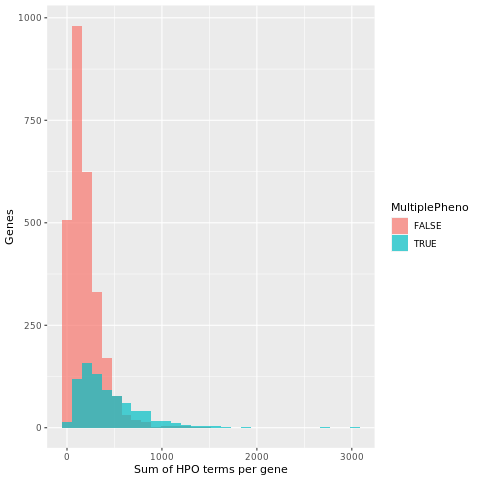

In [86]:
%%R 

hist_hpo <- ggplot(count_terms, aes(x=Sum_HPO, fill=MultiplePheno)) + geom_histogram(alpha=0.7, position="identity") + theme_bw()+ theme(axis.text = element_text(size = 10), axis.title =  element_text(size=14, face="bold")) + xlab('Sum of HPO terms per gene') + ylab('Genes')
hist_hpo <- hist_hpo + theme(legend.position = c(0.8, 0.8), legend.title = element_text(colour="black", size=16,face="bold"),  legend.text = element_text(colour="black", size=14)) + theme_set(theme_gray(base_family = "DejaVu"))
hist_hpo

## Enrichment analysis 

### collect genes with 2+ asscoiated diseases

In [53]:
ensembl_id = pd.read_csv('./mimgenes.txt', sep='\t')
gene_mim = gene_mim.merge(ensembl_id, left_on=['GENE'], right_on=['Approved Gene Symbol (HGNC)'], how='inner')
gene_mim = gene_mim.drop(columns=['Approved Gene Symbol (HGNC)'])

In [55]:
# List of genes with multiple associated phenotypes for Enrichment Analysis

genesmultipheno_for_EA = gene_mim[gene_mim['MIMs_per_Gene'] > 1]
genesmultipheno_for_EA = genesmultipheno_for_EA[['GENE', 'Ensembl']].drop_duplicates()
genesmultipheno_for_EA.to_csv('./interm/GeneMultiPheno_ensg_for_EA_hpo_data.csv', sep='\t', index=False)

In [56]:
%%R -i genesmultipheno_for_EA

mgene <- unique(genesmultipheno_for_EA$Ensembl)
length(mgene)

[1] 931


In [65]:
# set universe as all genes from dataframe

universe = gene_mim[['Ensembl']].drop_duplicates()
universe.to_csv('./interm/df_genelist_hpo_data.csv', sep='\t', index=False)
universe.shape[0]

3900

### C2.Canonical Pathways collection 

In [60]:
%%R -i universe

### load collection
C2.CP <- as.data.frame(msigdbr(species = "Homo sapiens", 
                               category = "C2",
                               subcategory = "CP:BIOCARTA")) %>% 
  bind_rows(as.data.frame(msigdbr(species = "Homo sapiens", 
                                  category = "C2",
                                  subcategory = "CP:KEGG"))) %>% 
  bind_rows(as.data.frame(msigdbr(species = "Homo sapiens", 
                                  category = "C2",
                                  subcategory = "CP:PID"))) %>% 
  bind_rows(as.data.frame(msigdbr(species = "Homo sapiens", 
                                  category = "C2",
                                  subcategory = "CP:REACTOME")))


## subset collection based on OMIM genes for enrichment

C2.CP <- C2.CP %>% 
  dplyr::select(gs_name, ensembl_gene)

C2CP_t2g <-C2.CP %>%
  filter(ensembl_gene %in% universe$Ensembl)

print(nrow(C2.CP))
print(nrow(C2CP_t2g))

[1] 130371
[1] 33699


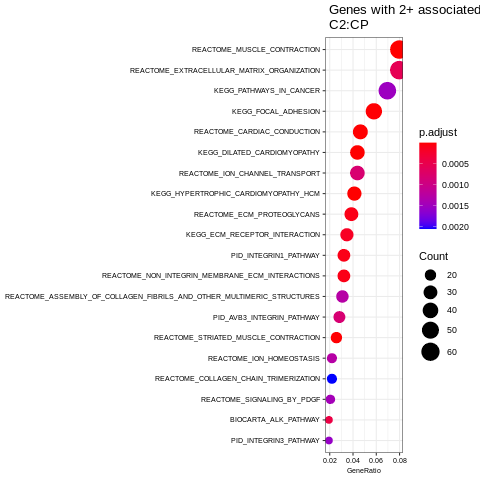

In [61]:
%%R

mres_C2CP <- enricher(mgene, TERM2GENE = C2CP_t2g)

dotplot(mres_C2CP, showCategory = 20,font.size = 7)+ ggtitle(' Genes with 2+ associated diseases \n C2:СР')

### C5.HPO collection

In [62]:
%%R -i universe

C5.HPO <- msigdbr(species = "Homo sapiens", category = "C5", subcategory = "HPO")

HPO <- C5.HPO %>% 
  dplyr::select(gs_name, ensembl_gene)

C5HPO_t2g <-HPO %>%
  filter(ensembl_gene %in% universe$Ensembl)

print(nrow(HPO))
print(nrow(C5HPO_t2g))

[1] 464649
[1] 337013


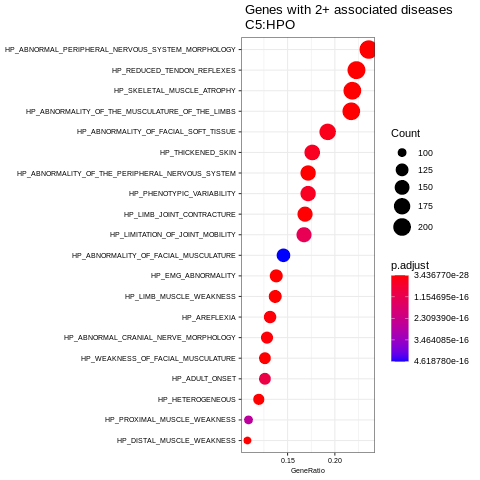

In [63]:
%%R

mres_C5 <- enricher(mgene, TERM2GENE = C5HPO_t2g)

dotplot(mres_C5, showCategory = 20,font.size = 7) + ggtitle(' Genes with 2+ associated diseases \n C5:HPO')
